# Predicting house prices using k-nearest neighbors regression

### - Find the k-nearest neighbors of a given query input
### - Predict the output for the query input using the k-nearest neighbors
### - Choose the best value of k using a validation set

In [1]:
import pandas as pd
import numpy as np

# Load in house sales data
### we use a subset of the King County housing dataset created by randomly selecting 40% of the houses in the full dataset

In [2]:
kc = pd.read_csv('kc_house_data_small.csv')

In [3]:
kc_train = pd.read_csv('kc_house_data_small_train.csv')
kc_test = pd.read_csv('kc_house_data_small_test.csv')
kc_valid = pd.read_csv('kc_house_data_validation.csv')

# Import useful functions
### To efficiently compute pairwise distances among data points, we will convert the SFrame into a 2D Numpy array.

In [4]:
def get_numpy_data(df,features,output):
    df['constant']=1 # this is for adding a column named 'constant' to a DataFrame
    constant = pd.DataFrame(df['constant'])   
# adding the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = constant.join(df[features])
    feature_matrix = features.to_numpy() # converting dataframe into a numpy array
    output_array = df[output].to_numpy()
    return feature_matrix,output_array

In [5]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix,axis=0)
    normalize_feature_matrix = feature_matrix/norms
    return normalize_feature_matrix,norms

# Extract features and normalize¶
### Using all of the numerical inputs listed in features , transforming the training, test, and validation DataFrames into Numpy arrays:



In [6]:
features = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']

In [7]:
train_feature_matrix,train_output = get_numpy_data(kc_train,features,'price')
test_feature_matrix,test_output = get_numpy_data(kc_test,features,'price')
valid_feature_matrix,valid_output = get_numpy_data(kc_valid,features,'price')

### In computing distances, it is crucial to normalize features. Otherwise, for example, the sqft_living feature (typically on the order of thousands) would exert a much larger influence on distance than the bedrooms feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.
### Note: Making sure to store the norms of the features in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [8]:
normalized_feature_train,norms = normalize_features(train_feature_matrix)
normalized_feature_test = test_feature_matrix/norms
normalized_feature_valid = valid_feature_matrix/norms

In [9]:
dist = normalized_feature_test[0]-normalized_feature_train[9]

In [10]:
euclidean_dist = np.sqrt(dist@dist)

In [11]:
euclidean_dist

0.059723593713980776

# Compute multiple distances¶
#### To do nearest neighbor regression, we need to compute the distance between our query house and all houses in the training set.
#### Using a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [12]:
dist_10 = []

In [13]:
for i in range(10):
    distance = normalized_feature_test[0]-normalized_feature_train[i]
    euclidean_distance = np.sqrt(distance@distance)
    dist_10.append(euclidean_distance)

In [14]:
dist_10

[0.06027470916295592,
 0.08546881147643746,
 0.06149946435279315,
 0.053402739792943625,
 0.05844484060170442,
 0.059879215098128345,
 0.0546314049677546,
 0.05543108323614607,
 0.052383627840220305,
 0.059723593713980776]

In [15]:
dist_10.index(min(dist_10))

8

In [16]:
def compute_distances(train_matrix, query_vector):
    diff = train_matrix - query_vector
    distances = np.sqrt(np.sum(diff**2, axis=1))
    return distances

In [17]:
third_test_house = compute_distances(normalized_feature_train,normalized_feature_test[2])

In [18]:
np.where(third_test_house==min(third_test_house))

(array([382], dtype=int64),)

In [19]:
third_test_house[382]

0.0028604955575117085

In [20]:
kc_train['price'][382]

249000

# Perform k-nearest neighbor regression
#### For k-nearest neighbors, we need to find a set of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.
## Fetch k-nearest neighbors¶
### Using the functions above and implementing a function that takes in

#### - the value of k;
#### - the feature matrix for the training houses; and
#### - the feature vector of the query house
#### and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.


In [21]:
def compute_k_nearest_neighbors(k, features_matrix, feature_vector):
    distances = compute_distances(features_matrix, feature_vector)
    return np.argsort(distances, axis = 0)[:k]

In [22]:
compute_k_nearest_neighbors(4,normalized_feature_train,normalized_feature_test[2])

array([ 382, 1149, 4087, 3142], dtype=int64)

# Make a single prediction by averaging k nearest neighbor outputs¶
### Writing a function to predict the value of each and every house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:
#### - the value of k;
#### - the feature matrix for the training houses;
#### - the output values (prices) of the training houses; and
#### - the feature matrix for the query set.
#### This function returns a set of predicted values, one for each house in the query set.

In [23]:
def predict_output_of_query(k, features_train, output_train, features_query):
    arr = compute_k_nearest_neighbors(k, features_train,features_query )
    prediction = 0
    for i in range(k):
        prediction += output_train[arr[i]]
    prediction = prediction/k
    return prediction

In [24]:
predict_output_of_query(4,normalized_feature_train,kc_train['price'],normalized_feature_test[2])

413987.5

In [25]:
def predict_output(k, features_train, output_train, features_query):
    predictions =[]
    for i in range(len(features_query)):
        predict = predict_output_of_query(k, features_train, output_train, features_query[i])
        predictions.append(predict)
    return predictions

In [26]:
predictions = predict_output(10,normalized_feature_train,kc_train['price'],normalized_feature_test[:10])

In [27]:
predictions.index(min(predictions))

6

In [28]:
predictions[6]

350032.0

# Choosing the best value of k using a validation set¶
### There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. We loop through the following:

### For k in [1, 2, ..., 15]:
### Making predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
### Computing the RSS for these predictions on the VALIDATION set
### Storing the RSS computed above in rss_all
### Reporting which k produced the lowest RSS on VALIDATION set.

In [29]:
rss = []
for k in range(1,16):
    predict_valid = predict_output(k,normalized_feature_train,train_output,normalized_feature_valid)
    RSS = predict_valid-valid_output
    RSS = sum(RSS**2)
    rss.append(RSS)

In [30]:
rss.index(min(rss))

7

In [31]:
predicted_test_price = predict_output(7,normalized_feature_train,train_output,normalized_feature_test)

In [32]:
rss_test = predicted_test_price-kc_test['price']
rss_test = rss_test@rss_test

In [33]:
rss_test

131757081714411.9

In [34]:
rss

[105453830251561.0,
 83445073504025.5,
 72692096019202.8,
 71946721652091.69,
 69846517419718.586,
 68899544353181.09,
 68341973450051.055,
 67361678735491.5,
 68372727958976.336,
 69335048668556.7,
 69523855215598.875,
 69049969587246.45,
 70011254508263.625,
 70908698869034.44,
 71106928385945.36]

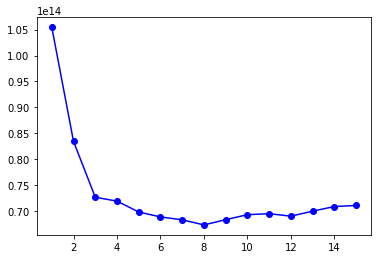

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss,'bo-')